good sources about this model :

https://youtu.be/A-yKQamf2Fc

https://dsgiitr.com/blogs/gat/

Can we do better than GCNs? 

From Graph Convolutional Network (GCN), we learnt that combining local graph structure and node-level features yields good performance on node classification task. However, the way GCN aggregates messages is structure-dependent, which may hurt its generalizability.


**GAT (Graph Attention Network)**, is a novel neural network architecture that operate on graph-structured data, leveraging masked self-attentional layers to address the shortcomings of prior methods based on graph convolutions or their approximations.
The fundamental novelty that GAT brings to the table is how the information from the one-hop neighborhood is aggregated.

In [1]:
%cd DATA

/home/ubuntu/workspace/GNNs-on-Biological-data/DATA


In [2]:
import pandas as pd
import sys
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import networkx as nx
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
import os.path as osp
import matplotlib.pyplot as plt
import time
import warnings
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import GATConv, BatchNorm
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GNNExplainer

from sklearn.model_selection import train_test_split
from torch_geometric.data import InMemoryDataset
from sklearn.preprocessing import StandardScaler
# from torch_geometric.utils import metric

In [3]:
def filter_disease(disease_gene_association_file, disease_name="Asthma"):
    columns = ['diseaseName', 'geneSymbol']
    df = pd.read_csv(disease_gene_association_file, sep='\t',usecols=columns)
    
    is_disease =  df['diseaseName']==disease_name # first disease to be examined , comment this for checking for other disease and uncooment following
    #is_disease =  df['diseaseName']=="Asthma"
    df_disease = df[is_disease]
    return df_disease

In [4]:
def create_G(biogrid_file_name,df_disease):
    biogrid = open(biogrid_file_name, 'r')
    lines=biogrid.readlines()
    G=nx.Graph()
    for line in tqdm(lines):
        x=line.split()
        if df_disease['geneSymbol'].str.contains(x[0]).any():
            G.add_node(x[0],label=1)
        else:
            G.add_node(x[0],label=0)
        if df_disease['geneSymbol'].str.contains(x[1]).any(): 
            G.add_node(x[1],label=1)
        else:  
            G.add_node(x[1],label=0)
        G.add_edge(x[0], x[1])
      #  G.add_edge(x[0], x[0]) # i decided to include an edge from node to itself to have adj matrix with himself included
       # G.add_edge(x[1], x[1])
    biogrid.close()
    G=nx.convert_node_labels_to_integers(G)
    #print(nx.info(G))
    return G

In [5]:
def create_balanced_G(biogrid_file_name,df_disease):
    biogrid = open(biogrid_file_name, 'r')
    lines=biogrid.readlines()
    G=nx.Graph()
    ones=zeros=0
    i=0
    nums=[0]
    for line in tqdm(lines):
        x=line.split()
        if df_disease['geneSymbol'].str.contains(x[0]).any():
            G.add_node(x[0],label=1)
            ones=1+ones
        else :
          num=random.randint(0,100)
          if num in nums:
             G.add_node(x[0],label=0)
             zeros=zeros+1
             

        if df_disease['geneSymbol'].str.contains(x[1]).any(): 
            G.add_node(x[1],label=1)
            ones=1+ones
        else:
          num=random.randint(0,4000)
          if num in nums:
            G.add_node(x[1],label=0)
            zeros=1+zeros
        
        if G.has_node(x[0]) and G.has_node(x[1]):
            G.add_edge(x[0], x[1])
        i+=1
        if i%100000 ==0:
            #print("p = ",ones/(ones+zeros))
            #print(ones)
            #print(zeros)
            attribute_counter(G)
        

    biogrid.close()
    G=nx.convert_node_labels_to_integers(G)
    #print(nx.info(G))
    return G

In [6]:
def attribute_counter(G):
  zeros=0
  ones=0
  for node in tqdm(list(G.nodes())):
    if G.nodes[node]['label']==0:
      zeros+=1
    else:
      ones+=1
  print("#zeros: ", zeros)
  print("#ones: ", ones)
  print("portion of ones " ,ones/(ones+zeros) )

In [7]:
disease_name = "Schizophrenia"

In [8]:
# print(" (0/6) started ")
# #disease_gene_association_file="all_gene_disease_associations.tsv"  #current directory / this is real file not test file
# disease_gene_association_file="curated_gene_disease_associations.tsv"
# df_disease=filter_disease(disease_gene_association_file, disease_name=disease_name)
# print(" (1/6) disease dataframe creation : done")
                   
# #biogrid_file_name='Biogrid_REDUX.txt'
# biogrid_file_name='Biogrid_4.4.199_Hs.txt'
# G=create_G(biogrid_file_name,df_disease)
# print(" (2/6) Graph creation : done")

In [9]:
# balanced_G = create_balanced_G(biogrid_file_name,df_disease)

In [10]:
# attribute_counter(balanced_G)

In [11]:
# nx.write_gpickle(balanced_G, f"{disease_name}_balanced_more.gpickle")

In [12]:
balanced_G = nx.read_gpickle(f"{disease_name}_balanced_more.gpickle")
nx.info(balanced_G)
attribute_counter(balanced_G)

/tmp/ipykernel_1206925/443878142.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(balanced_G)
100%|██████████| 1329/1329 [00:00<00:00, 3083091.82it/s]

#zeros:  314
#ones:  1015
portion of ones  0.763732129420617


In [13]:
G=balanced_G

In [14]:
# retrieve the labels for each node, the nodes that are not zero
labels = np.asarray([G.nodes[i]['label'] != 0 for i in G.nodes]).astype(np.int64)

# create edge index. We need to have data as previously shown. We can exploit networkX and scipy for that 
adj = nx.to_scipy_sparse_matrix(G).tocoo() #coordinate format
#print(adj)

/tmp/ipykernel_1206925/2791777853.py:5: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  adj = nx.to_scipy_sparse_matrix(G).tocoo() #coordinate format


In [15]:
#create edge index in the proper way
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long) #create a torch tensor from numpy in long format : for row indexes
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long) #                                                   for column indexes
edge_index = torch.stack([row, col], dim=0)
#display(edge_index)

In [16]:
# using degree as embedding. For simplicity, the feature vector describing the 
# will be just its degree, which is enough for us   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>.. can i use other embeddings? https://medium.com/@st3llasia/graph-embedding-techniques-7d5386c88c5
#is it actually working or we do it for simplicity
embeddings = np.array(list(dict(G.degree()).values())) #list the values of degree of each node as numpy array
# normalizing degree values

scale = StandardScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))
print(embeddings)

[[ 1.75713634]
 [ 3.30852095]
 [ 4.45954824]
 ...
 [ 0.00557307]
 [-0.54491824]
 [ 0.25579639]]


In [17]:
# custom pytorch dataset
class PPIDATASET(InMemoryDataset):
    def __init__(self, transform=None):
        super(PPIDATASET, self).__init__('.', transform, None, None) #pre transform and pre filter: None, we don't need them
        data = Data(edge_index=edge_index) #Data : A data object describing a homogeneous graph.  for more : https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
        data.num_nodes = G.number_of_nodes()
        # embedding 
        data.x = torch.from_numpy(embeddings).type(torch.float32)
        # labels
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach() #removing tensors computational graph for efficency since it is not needed
        data.num_classes = 2
        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(G.nodes()),  pd.Series(labels), test_size=0.30, random_state=42)
        n_nodes = G.number_of_nodes()
        # create train and test masks for data
        # the Data objects holds a label for each node, and additional node-level attributes: train_mask, val_mask and test_mask, where
        #train_mask denotes against which nodes to train (140 nodes),
        #val_mask denotes which nodes to use for validation, e.g., t
        #test_mask denotes against which nodes to test 
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask
        self.data, self.slices = self.collate([data])
    # def _download(self):
    #     return
    # def _process(self):
    #     return
    # def __repr__(self):
    #     return '{}()'.format(self.__class__.__name__)

In [18]:
dataset = PPIDATASET()
#Here, the dataset contains only a single, undirected citation graph, reminder: dataset is like a dictionary that hold the graph inside, here the dictionary
#has only one elemetns:
data = dataset[0] #now data is ready for training and testing

In [19]:
# # Model Definition
# class GAT(torch.nn.Module):
#     def __init__(self):
#         super(GAT, self).__init__()
#         self.hid = 8     #input channels
#         self.in_head = 8 #output channels
#         self.out_head = 1 #output head
#         #suggestion for later ::::: concatanation:true: for intermadiate layers
#         self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.7)
#         self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False, heads=self.out_head, dropout=0.7)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.dropout(x, p=0.7, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.7, training=self.training)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)


In [20]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.hid1 = 128  # Number of channels in the first hidden layer
        self.hid2 = 256  # Number of channels in the second hidden layer
        self.in_head = 8  # Number of attention heads for the first layer
        self.mid_head = 4  # Number of attention heads for the intermediate layer
        self.out_head = 1  # Number of attention heads for the output layer

        # First GAT layer: from input features to the first hidden layer
        self.conv1 = GATConv(num_features, self.hid1, heads=self.in_head, dropout=0.6)
        self.bn1 = BatchNorm(self.hid1 * self.in_head)  # Batch normalization

        # Second GAT layer: from the first hidden layer to the second hidden layer
        self.conv2 = GATConv(self.hid1 * self.in_head, self.hid2, heads=self.mid_head, dropout=0.6)
        self.bn2 = BatchNorm(self.hid2 * self.mid_head)  # Batch normalization

        # Third GAT layer: from the second hidden layer to the output layer
        self.conv3 = GATConv(self.hid2 * self.mid_head, num_classes, concat=False, heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index  # Extract input features and edge indices

        # First layer
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bn1(x)

        # Second layer
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.bn2(x)

        # Third layer
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)  # Output log-probabilities for each class

In [21]:
# Seed for reproducible numbers
torch.manual_seed(1)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

it is so fast on gpu that it becomes difficult to compare the models. if ran on cpu, it can be seen GAT is slower, for the same graph

In [22]:
# Train
model = GAT(data.num_features, 2).to(device)
data = dataset[0].to(device)

# Adam Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-3)

# Training Loop
model.train()
tick=time.time()
for epoch in tqdm(range(100)):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])    
    
    if epoch%10 == 0:
        print(loss)
    loss.backward()
    optimizer.step()
    
tock=time.time()


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(1.1614, grad_fn=<NllLossBackward0>)


 10%|█         | 10/100 [00:04<00:38,  2.35it/s]

tensor(0.8914, grad_fn=<NllLossBackward0>)


 20%|██        | 20/100 [00:08<00:35,  2.25it/s]

tensor(1.0393, grad_fn=<NllLossBackward0>)


 30%|███       | 30/100 [00:13<00:33,  2.08it/s]

tensor(0.8248, grad_fn=<NllLossBackward0>)


 40%|████      | 40/100 [00:17<00:27,  2.20it/s]

tensor(0.7209, grad_fn=<NllLossBackward0>)


 50%|█████     | 50/100 [00:22<00:23,  2.10it/s]

tensor(0.7376, grad_fn=<NllLossBackward0>)


 60%|██████    | 60/100 [00:27<00:18,  2.19it/s]

tensor(0.6751, grad_fn=<NllLossBackward0>)


 70%|███████   | 70/100 [00:31<00:13,  2.19it/s]

tensor(0.6553, grad_fn=<NllLossBackward0>)


 80%|████████  | 80/100 [00:36<00:09,  2.11it/s]

tensor(0.7091, grad_fn=<NllLossBackward0>)


 90%|█████████ | 90/100 [00:41<00:04,  2.09it/s]

tensor(0.6945, grad_fn=<NllLossBackward0>)


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


In [23]:
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

accuracy = Accuracy(task='binary').to(device)
precision = Precision(task='binary').to(device)
recall = Recall(task='binary').to(device)
f1 = F1Score(task='binary').to(device)
confmat = ConfusionMatrix(task='binary').to(device)

In [24]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()

test_pred = pred[data.test_mask].view(-1).to(device)
test_gt = data.y[data.test_mask].view(-1).to(device)

test_acc = accuracy(test_pred, test_gt)
test_precision = precision(test_pred, test_gt)
test_f1score = f1(test_pred, test_gt)
test_recall = recall(test_pred, test_gt)
conf_matrix = confmat(test_pred, test_gt)

TN, FP, FN, TP = conf_matrix.view(-1).tolist()

print("training done in ",(tock-tick),"seconds")
print('Test Accuracy: %s' % test_acc.item())
print('test precision: %s' % test_precision.item())
print('Test f1 score: %s' % test_f1score.item())
print('Test recall: %s' % test_recall.item())
print(" #### confusion matrix test: ")
print("TP", TP, "FP", FP)
print("TN", TN, "FN", FN)

training done in  45.842190742492676 seconds
Test Accuracy: 0.7819548845291138
test precision: 0.7819548845291138
Test f1 score: 0.8776371479034424
Test recall: 1.0
 #### confusion matrix test: 
TP 312 FP 87
TN 0 FN 0


In [25]:
train_pred = pred[data.train_mask].view(-1).to(device)
train_gt = data.y[data.train_mask].view(-1).to(device)

train_acc = accuracy(train_pred, train_gt)
train_precision = precision(train_pred, train_gt)
train_f1score = f1(train_pred, train_gt)
train_recall = recall(train_pred, train_gt)
conf_matrix = confmat(train_pred, train_gt)

TN, FP, FN, TP = conf_matrix.view(-1).tolist()

print("training done in ",(tock-tick),"seconds")
print('Train Accuracy: %s' % train_acc.item())
print('train precision: %s' % train_precision.item())
print('Train f1 score: %s' % train_f1score.item())
print('Train recall: %s' % train_recall.item())
print(" #### confusion matrix train: ")
print("TP", TP, "FP", FP)
print("TN", TN, "FN", FN)

training done in  45.842190742492676 seconds
Train Accuracy: 0.7559139728546143
train precision: 0.7559139728546143
Train f1 score: 0.8609920144081116
Train recall: 1.0
 #### confusion matrix train: 
TP 703 FP 227
TN 0 FN 0


In [26]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.hid1 = 128  # Number of channels in the first hidden layer
        self.hid2 = 256  # Number of channels in the second hidden layer
        self.in_head = 8  # Number of attention heads for the first layer
        self.mid_head = 4  # Number of attention heads for the intermediate layer
        self.out_head = 1  # Number of attention heads for the output layer

        # First GAT layer: from input features to the first hidden layer
        self.conv1 = GATConv(num_features, self.hid1, heads=self.in_head, dropout=0.6)
        self.bn1 = BatchNorm(self.hid1 * self.in_head)  # Batch normalization

        # Second GAT layer: from the first hidden layer to the second hidden layer
        self.conv2 = GATConv(self.hid1 * self.in_head, self.hid2, heads=self.mid_head, dropout=0.6)
        self.bn2 = BatchNorm(self.hid2 * self.mid_head)  # Batch normalization

        # Third GAT layer: from the second hidden layer to the output layer
        self.conv3 = GATConv(self.hid2 * self.mid_head, num_classes, concat=False, heads=self.out_head, dropout=0.6)

    def forward(self, x, edge_index):
        
        # First layer
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bn1(x)

        # Second layer
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.bn2(x)

        # Third layer
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)  # Output log-probabilities for each class

In [27]:
torch.manual_seed(42)

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16, normalize=False)
        self.conv2 = GCNConv(16, dataset.num_classes, normalize=False)

    def forward(self, x, edge_index, edge_weight):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)

In [28]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = GAT(data.num_features, 2).to(device)
data = data.to(device)
lr = 1e-2

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 200

x, edge_index, edge_weight = data.x, data.edge_index, None

num_epochs = 200

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

with torch.no_grad():
  model.eval()
  logits = model(x, edge_index)

  #test_mask = data['test_mask']
  preds = logits.max(1)[1]

100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


In [29]:
explainer = GNNExplainer(model, epochs=200, return_type='log_prob', num_hops = None) #if num_hops is none it is detected from the num of message passing ops.
                                                                                  #it is needed to tell the explainer "how far to go" to look for explanations.
node_idx = 11
pred_node_idx = preds[node_idx].item()
print("Explaining node ", node_idx, " with predicted class: ", pred_node_idx)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)


Explaining node  11  with predicted class:  1


Explain node 11: 100%|██████████| 200/200 [01:13<00:00,  2.71it/s]


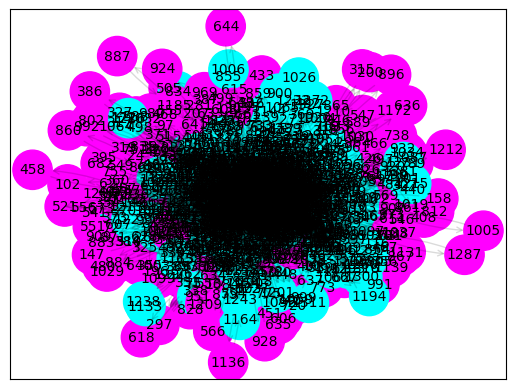

In [30]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y, seed = node_idx, threshold = None) #you can set threshold to define the hard mask accordign to the sparisty you wnat ot obtain and how much you want to be strict
plt.show()

In [31]:
nx.write_gpickle(G, f"{disease_name}_GAT_result.gpickle")